In [82]:
import pandas as pd
from pathlib import Path

In [83]:
files = {
    "user_paths": "data/processed/user_paths.csv",
    "rule_based": "data/processed/rule_based_attribution.csv",
    "markov": "data/processed/markov_attribution.csv",
    "comparison": "data/processed/attribution_comparison.csv",
    "campaign_lift": "data/processed/campaign_incrementality.csv",
    "channel_lift": "data/processed/channel_incrementality.csv",
    "channel_causal": "data/processed/channel_causal_aipw.csv"  # optional
}

In [84]:
dfs = {}
for name, path in files.items():
    p = Path(path)
    if p.exists():
        try:
            dfs[name] = pd.read_csv(p)
            print(f" Loaded {name} ({dfs[name].shape[0]} rows, {dfs[name].shape[1]} cols)")
        except Exception as e:
            print(f" Could not load {name}: {e}")
    else:
        print(f" Missing file: {name}")

 Loaded user_paths (2847 rows, 10 cols)
 Loaded rule_based (6 rows, 8 cols)
 Loaded markov (6 rows, 3 cols)
 Loaded comparison (6 rows, 14 cols)
 Loaded campaign_lift (5 rows, 7 cols)
 Loaded channel_lift (6 rows, 7 cols)
 Loaded channel_causal (6 rows, 7 cols)


In [85]:
TOP_N_PATHS = 15   # how many paths to include in the Sankey
OUT_DIR = Path("visuals")
OUT_DIR.mkdir(parents=True, exist_ok=True)


In [86]:
paths = pd.read_csv("data/processed/user_paths.csv")


In [87]:
expected_cols = {"User ID","Path","Path_Conversion","path_length","n_unique_channels"}
missing = expected_cols - set(paths.columns)
if missing:
    raise ValueError(f"user_paths.csv missing columns: {missing}")
paths["Path"] = paths["Path"].fillna("").astype(str)


In [88]:
import plotly.graph_objects as go


In [89]:
path_counts = (paths.groupby(["Path", "Path_Conversion"])
                    .size()
                    .reset_index(name="users"))
top_paths = (path_counts.sort_values("users", ascending=False)
                        .head(TOP_N_PATHS))


In [90]:
def path_to_pairs(path_str, converted):
    chans = [c.strip() for c in path_str.split(">") if c.strip()]
    pairs = []
    if not chans:
        return pairs
    # consecutive steps
    for a, b in zip(chans[:-1], chans[1:]):
        pairs.append((a, b))
    # terminal
    terminal = "Conversion" if int(converted) == 1 else "Null"
    pairs.append((chans[-1], terminal))
    return pairs


In [91]:
pairs_weight = {}
for _, row in top_paths.iterrows():
    pairs = path_to_pairs(row["Path"], row["Path_Conversion"])
    for p in pairs:
        pairs_weight[p] = pairs_weight.get(p, 0) + int(row["users"])


In [92]:
nodes = sorted(list(set([a for a, _ in pairs_weight.keys()]) |
                    set([b for _, b in pairs_weight.keys()])))
node_index = {n: i for i, n in enumerate(nodes)}


In [93]:
sources = [node_index[a] for (a, b) in pairs_weight.keys()]
targets = [node_index[b] for (a, b) in pairs_weight.keys()]
values  = list(pairs_weight.values())


In [94]:
fig_sankey = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15, thickness=18,
        label=nodes
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])
fig_sankey.update_layout(
    title=f"Top {TOP_N_PATHS} User Paths (Sankey)",
    font_size=12
)
fig_sankey.show()

In [95]:
sankey_path = OUT_DIR / "attribution_sankey.html"
fig_sankey.write_html(str(sankey_path))
print(f"Sankey saved to {sankey_path}")

Sankey saved to visuals/attribution_sankey.html


In [96]:
import matplotlib.pyplot as plt


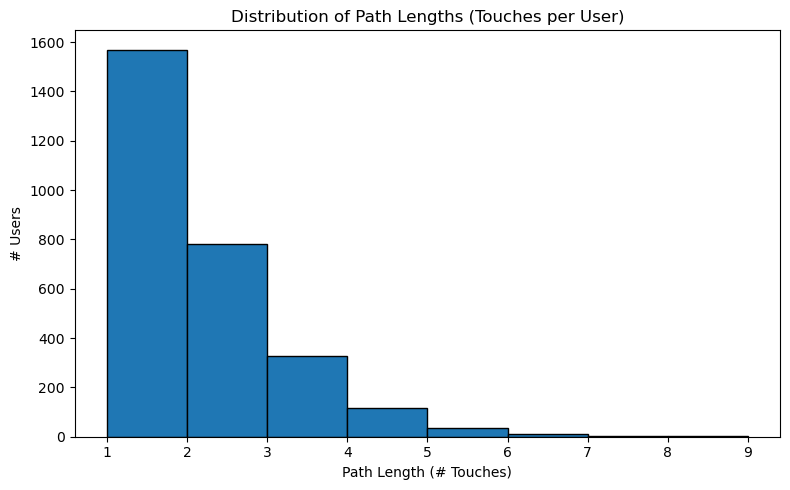

 Histogram saved to visuals/path_length_histogram.png


In [97]:
plt.figure(figsize=(8,5))
plt.hist(paths["path_length"], bins=range(1, paths["path_length"].max()+2), edgecolor="black")
plt.title("Distribution of Path Lengths (Touches per User)")
plt.xlabel("Path Length (# Touches)")
plt.ylabel("# Users")
plt.tight_layout()
hist_path = OUT_DIR / "path_length_histogram.png"
plt.savefig(hist_path, dpi=150)
plt.show()
print(f" Histogram saved to {hist_path}")

In [98]:
pathlen_summary = (paths.groupby("path_length")["Path_Conversion"]
                        .agg(["mean","count"])
                        .reset_index()
                        .rename(columns={"mean":"cvr","count":"users"}))


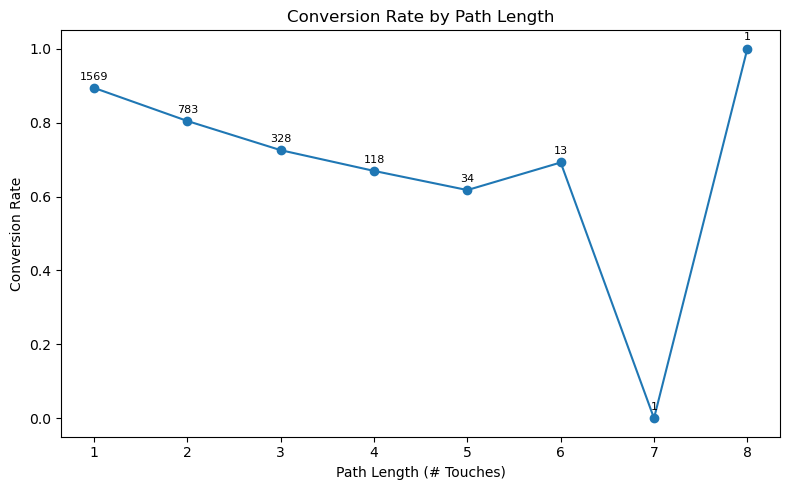

 Line chart saved to visuals/cvr_by_path_length.png


In [99]:
plt.figure(figsize=(8,5))
plt.plot(pathlen_summary["path_length"], pathlen_summary["cvr"], marker="o")
plt.title("Conversion Rate by Path Length")
plt.xlabel("Path Length (# Touches)")
plt.ylabel("Conversion Rate")

for _, r in pathlen_summary.iterrows():
    plt.annotate(int(r["users"]), (r["path_length"], r["cvr"]), textcoords="offset points", xytext=(0,6), ha="center", fontsize=8)
plt.tight_layout()
line_path = OUT_DIR / "cvr_by_path_length.png"
plt.savefig(line_path, dpi=150)
plt.show()
print(f" Line chart saved to {line_path}")

In [100]:
import numpy as np

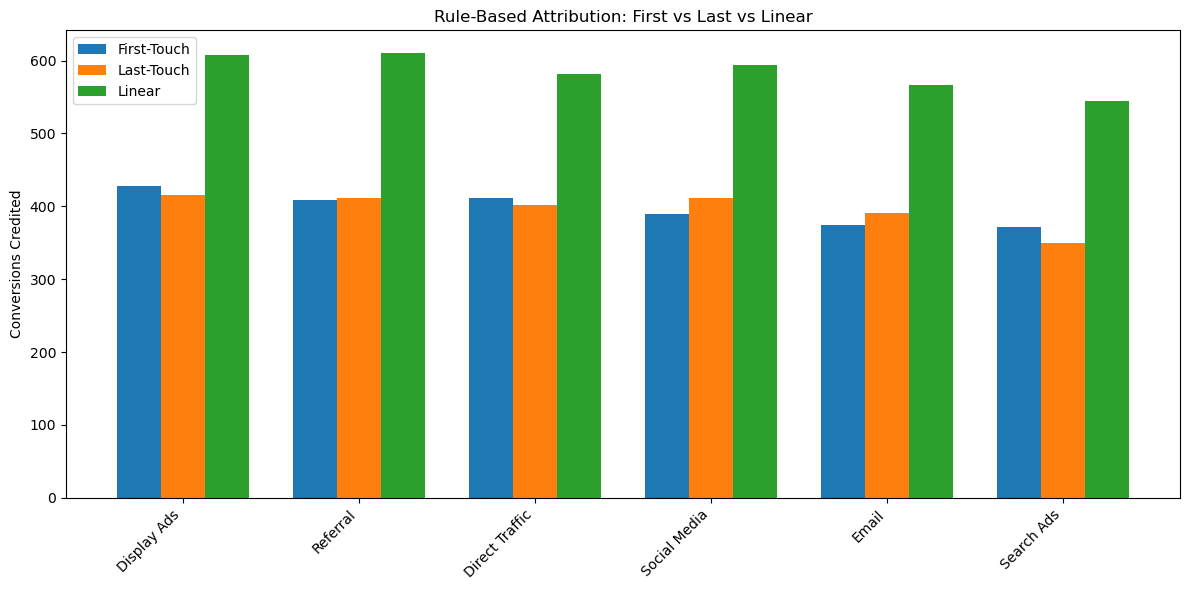

In [101]:
rb = pd.read_csv("data/processed/rule_based_attribution.csv")

for col in ["First_Touch","Last_Touch","Linear"]:
    if col not in rb.columns:
        raise ValueError(f"Column {col} missing from rule_based_attribution.csv")

N = 12
rb["_any"] = rb[["First_Touch","Last_Touch","Linear"]].sum(axis=1)
rb_top = rb.sort_values("_any", ascending=False).head(N)

labels = rb_top["Channel"].tolist()
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width, rb_top["First_Touch"], width=width, label="First-Touch")
ax.bar(x,          rb_top["Last_Touch"], width=width, label="Last-Touch")
ax.bar(x + width,  rb_top["Linear"],     width=width, label="Linear")

ax.set_title("Rule-Based Attribution: First vs Last vs Linear")
ax.set_ylabel("Conversions Credited")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.savefig("visuals/rule_based_attribution_bar.png", dpi=150)
plt.show()


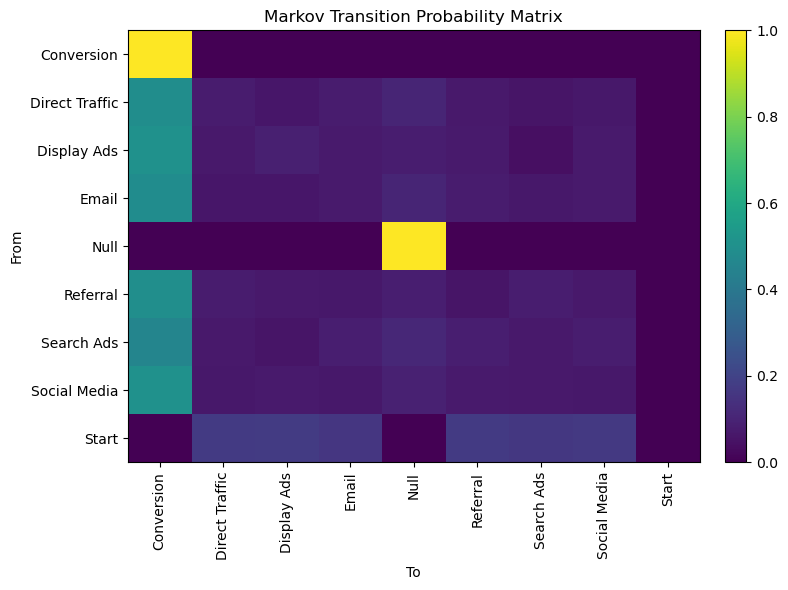

In [102]:
states = tm.index.tolist()
M = tm.values  

plt.figure(figsize=(max(8, 0.4*len(states)), max(6, 0.4*len(states))))
im = plt.imshow(M, aspect="auto", interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Markov Transition Probability Matrix")
plt.xlabel("To")
plt.ylabel("From")
plt.xticks(ticks=np.arange(len(states)), labels=states, rotation=90)
plt.yticks(ticks=np.arange(len(states)), labels=states)
plt.tight_layout()
out = VIS_DIR / "markov_transition_heatmap.png"
plt.savefig(out, dpi=150)
plt.show()

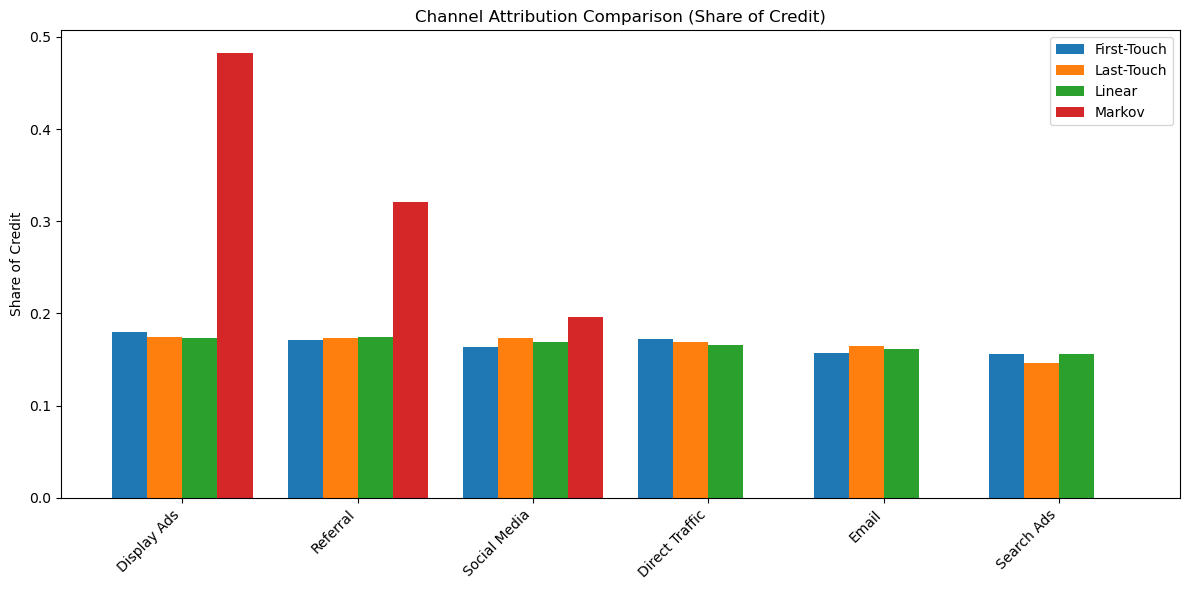

Saved visuals/rule_vs_markov_grouped_bar.png


In [103]:
N = 12
cmp["Any_Share"] = (cmp["First_Touch_Share"] + cmp["Last_Touch_Share"]
                    + cmp["Linear_Share"] + cmp["Markov_Share"])
cmp_top = cmp.sort_values("Any_Share", ascending=False).head(N).copy()

labels = cmp_top["Channel"].astype(str).tolist()
x = np.arange(len(labels))
width = 0.2

plt.figure(figsize=(12,6))
plt.bar(x - 1.5*width, cmp_top["First_Touch_Share"], width=width, label="First-Touch")
plt.bar(x - 0.5*width, cmp_top["Last_Touch_Share"],  width=width, label="Last-Touch")
plt.bar(x + 0.5*width, cmp_top["Linear_Share"],      width=width, label="Linear")
plt.bar(x + 1.5*width, cmp_top["Markov_Share"],      width=width, label="Markov")

plt.title("Channel Attribution Comparison (Share of Credit)")
plt.ylabel("Share of Credit")
plt.xticks(x, labels, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
out = VIS_DIR / "rule_vs_markov_grouped_bar.png"
plt.savefig(out, dpi=150)
plt.show()
print(f"Saved {out}")


In [104]:
camp = pd.read_csv("data/processed/campaign_incrementality.csv")
chan = pd.read_csv("data/processed/channel_incrementality.csv")


CAUSAL_PATH = Path("data/processed/channel_causal_aipw.csv")
causal = pd.read_csv(CAUSAL_PATH) if CAUSAL_PATH.exists() else None


/var/folders/2y/200s60hs0g5bg1dmy0zrklmr0000gn/T/ipykernel_53334/1320756941.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



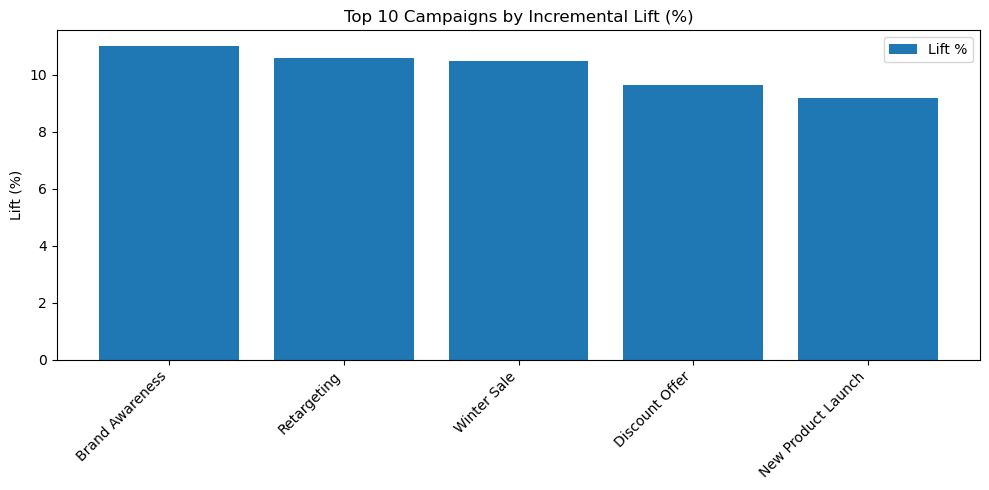

 Saved visuals/campaign_incremental_lift_top10.png


In [105]:

camp_plot = (camp.replace([np.inf, -np.inf], np.nan)
                 .dropna(subset=["Lift%"])
                 .sort_values("Lift%", ascending=False)
                 .head(10)
                 .copy())

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(camp_plot["Campaign"].astype(str), camp_plot["Lift%"], label="Lift %")
ax.set_title("Top 10 Campaigns by Incremental Lift (%)")
ax.set_ylabel("Lift (%)")
ax.set_xticklabels(camp_plot["Campaign"].astype(str), rotation=45, ha="right")
ax.legend()
plt.tight_layout()
out = VIS_DIR / "campaign_incremental_lift_top10.png"
plt.savefig(out, dpi=150)
plt.show()
print(f" Saved {out}")


/var/folders/2y/200s60hs0g5bg1dmy0zrklmr0000gn/T/ipykernel_53334/1660344150.py:10: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



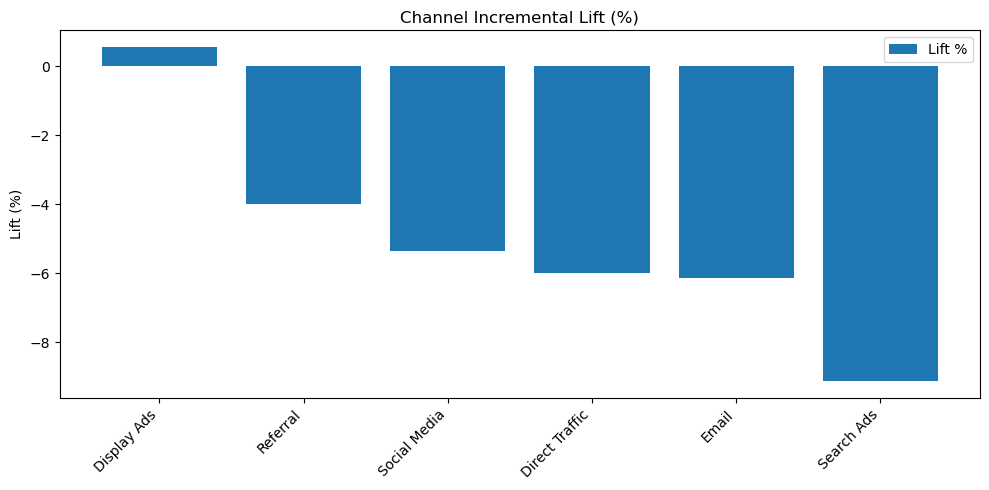

 Saved visuals/channel_incremental_lift.png


In [106]:

chan_plot = (chan.replace([np.inf, -np.inf], np.nan)
                 .dropna(subset=["Lift%"])
                 .sort_values("Lift%", ascending=False)
                 .copy())

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(chan_plot["Channel"].astype(str), chan_plot["Lift%"], label="Lift %")
ax.set_title("Channel Incremental Lift (%)")
ax.set_ylabel("Lift (%)")
ax.set_xticklabels(chan_plot["Channel"].astype(str), rotation=45, ha="right")
ax.legend()
plt.tight_layout()
out = VIS_DIR / "channel_incremental_lift.png"
plt.savefig(out, dpi=150)
plt.show()
print(f" Saved {out}")


/var/folders/2y/200s60hs0g5bg1dmy0zrklmr0000gn/T/ipykernel_53334/2842088022.py:26: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



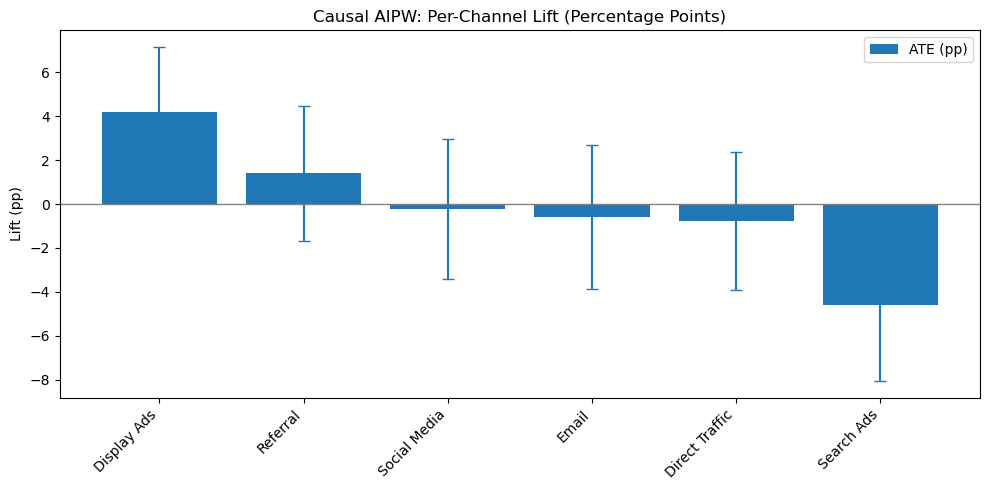

 Saved visuals/channel_causal_aipw_ATEpp.png


In [107]:
if causal is not None:
    required = {"Channel","ATE_pp","SE"}
    missing = required - set(causal.columns)
    if missing:
        print(f" Causal file is missing columns {missing}; skipping error-bar plot.")
    else:
        causal_plot = (causal.replace([np.inf, -np.inf], np.nan)
                             .dropna(subset=["ATE_pp"])
                             .copy())

        causal_plot = causal_plot.sort_values("ATE_pp", ascending=False)

        N = min(12, len(causal_plot))
        causal_plot = causal_plot.head(N)

        y = causal_plot["ATE_pp"].values
        yerr = (1.96 * causal_plot["SE"].values) if "SE" in causal_plot.columns else None

        fig, ax = plt.subplots(figsize=(10,5))
        ax.bar(causal_plot["Channel"].astype(str), y, label="ATE (pp)")
        if yerr is not None:
            ax.errorbar(causal_plot["Channel"].astype(str), y, yerr=yerr, fmt="none", capsize=4)

        ax.set_title("Causal AIPW: Per-Channel Lift (Percentage Points)")
        ax.set_ylabel("Lift (pp)")
        ax.set_xticklabels(causal_plot["Channel"].astype(str), rotation=45, ha="right")
        ax.axhline(0, color="gray", linewidth=1)
        ax.legend()
        plt.tight_layout()
        out = VIS_DIR / "channel_causal_aipw_ATEpp.png"
        plt.savefig(out, dpi=150)
        plt.show()
        print(f" Saved {out}")


In [108]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [109]:
TOP_N_PATHS = 12

path_counts = (
    paths.groupby(["Path","Path_Conversion"])
         .size().reset_index(name="users")
         .sort_values("users", ascending=False)
         .head(TOP_N_PATHS)
)


In [110]:
def path_to_pairs(path_str, converted):
    steps = [s.strip() for s in path_str.split(">") if s.strip()]
    pairs = []
    if not steps:
        return pairs
    for a, b in zip(steps[:-1], steps[1:]):
        pairs.append((a, b))
    terminal = "Conversion" if int(converted) == 1 else "Null"
    pairs.append((steps[-1], terminal))
    return pairs


In [111]:
pairs_weight = {}
for _, r in path_counts.iterrows():
    for p in path_to_pairs(r["Path"], r["Path_Conversion"]):
        pairs_weight[p] = pairs_weight.get(p, 0) + int(r["users"])


In [112]:
nodes = sorted(set([a for a,_ in pairs_weight]) | set([b for _,b in pairs_weight]))
node_index = {n:i for i,n in enumerate(nodes)}
sankey_source = [node_index[a] for (a,b) in pairs_weight]
sankey_target = [node_index[b] for (a,b) in pairs_weight]
sankey_value  = list(pairs_weight.values())


In [113]:
sankey = go.Sankey(
    node=dict(pad=12, thickness=16, label=nodes),
    link=dict(source=sankey_source, target=sankey_target, value=sankey_value)
)

In [114]:
N_ATTR = 10
cmp["Any_Share"] = (cmp["First_Touch_Share"] + cmp["Last_Touch_Share"]
                    + cmp["Linear_Share"] + cmp["Markov_Share"])
cmp_top = cmp.sort_values("Any_Share", ascending=False).head(N_ATTR).copy()

attr_bars = [
    go.Bar(name="First",  x=cmp_top["Channel"], y=cmp_top["First_Touch_Share"]),
    go.Bar(name="Last",   x=cmp_top["Channel"], y=cmp_top["Last_Touch_Share"]),
    go.Bar(name="Linear", x=cmp_top["Channel"], y=cmp_top["Linear_Share"]),
    go.Bar(name="Markov", x=cmp_top["Channel"], y=cmp_top["Markov_Share"])
]


In [115]:
camp_plot = (camp.replace([np.inf, -np.inf], np.nan)
                 .dropna(subset=["Lift%"])
                 .sort_values("Lift%", ascending=False)
                 .head(10))
camp_bar = go.Bar(x=camp_plot["Campaign"].astype(str), y=camp_plot["Lift%"], name="Campaign Lift %")

# ---------- D) Channel lift ----------
chan_plot = (chan.replace([np.inf, -np.inf], np.nan)
                 .dropna(subset=["Lift%"])
                 .sort_values("Lift%", ascending=False))
chan_bar = go.Bar(x=chan_plot["Channel"].astype(str), y=chan_plot["Lift%"], name="Channel Lift %")


In [116]:
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"type":"domain"}, {"type":"xy"}],
           [{"type":"xy"},     {"type":"xy"}]],
    subplot_titles=(
        "Top Paths (Sankey)",
        "Attribution Comparison (Shares)",
        "Top 10 Campaigns by Lift (%)",
        "Channel Lift (%)"
    )
)


In [117]:
fig.add_trace(sankey, row=1, col=1)
for t in attr_bars: fig.add_trace(t, row=1, col=2)
fig.add_trace(camp_bar, row=2, col=1)
fig.add_trace(chan_bar, row=2, col=2)


In [118]:
fig.update_layout(barmode="group", height=900, width=1300, showlegend=True)
fig.update_yaxes(title_text="Share", row=1, col=2)
fig.update_yaxes(title_text="Lift (%)", row=2, col=1)
fig.update_yaxes(title_text="Lift (%)", row=2, col=2)


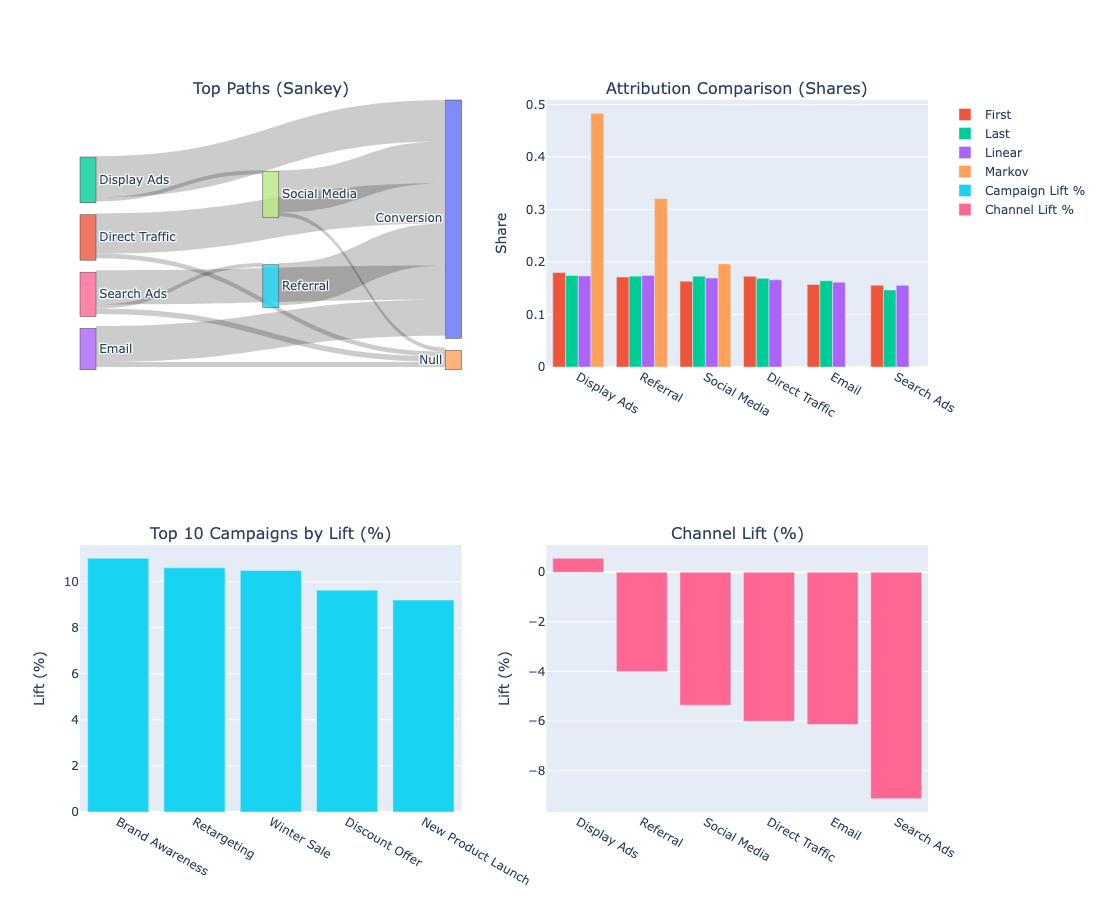

 Dashboard saved to visuals/dashboard_2x2.html


In [119]:
fig.show()
dash_path = VIS_DIR / "dashboard_2x2.html"
fig.write_html(str(dash_path))
print(f" Dashboard saved to {dash_path}")

# 📊 Marketing Attribution & Incrementality — Findings

## 1. Customer Journeys
- **Path Lengths**: Most users convert after only **1–2 touches**, with conversion rates declining as path length increases.  
- **Channel Sequences**: Sankey diagrams reveal that Email, Social Media, and Search Ads dominate the early and middle stages of user journeys.  
- **Conversion Dynamics**: Very long paths (>5 touches) rarely lead to conversions, confirming diminishing returns on extended exposure.  

## 2. Attribution Models

### Rule-Based Attribution
- *First-Touch*: Over-credits **Display Ads** and **Referral**, suggesting they play a bigger role in initial awareness.  
- *Last-Touch*: Over-credits **Email** and **Search Ads**, as they are common at the point of conversion.  
- *Linear*: Spreads credit evenly but ignores channel order and drop-off effects.  

### Markov Attribution
- Highlights the **true contribution** of channels by simulating removals.  
- Channels like **Referral** and **Social Media** emerge as more impactful than last-touch suggested, while **Email** is less dominant when path dependency is considered.  

## 3. Campaign Incrementality
- Campaign-level tests show **strong positive lift** across top campaigns:  
  - *Brand Awareness*: **+11% lift**  
  - *Retargeting*: **+10.6% lift**  
  - *Winter Sale & Discount Offers*: ~**+10% lift**  
- These campaigns not only drive conversions but also pass statistical significance checks (p < 0.01).  
- **Recommendation**: Scale budgets for Retargeting and Brand Awareness as they deliver the highest incremental gains.  

## 4. Channel Incrementality
- Incrementality at the channel level paints a nuanced picture:  
  - **Display Ads**: Modest positive lift (+0.6%), albeit not statistically significant.  
  - **Referral & Social Media**: Show **negative lift** (–4% to –5%), raising concerns about over-exposure or cannibalization.  
  - **Direct Traffic, Email, Search Ads**: Appear **less effective incrementally**, despite high attribution credit in last-touch models.  

### Causal AIPW (Adjusted)
- Confirms the story with odds ratios and error bars.  
- *Display Ads*: Positive and significant.  
- *Search Ads & Email*: Negative incremental effect.  
- Suggests reallocation away from lower incremental channels.  

## 5. Strategic Takeaways
- **Scale**: Brand Awareness and Retargeting campaigns.  
- **Reallocate**: Away from Search Ads and overused Email campaigns — they capture last-touch credit but show negative lift.  
- **Experiment**: With Display Ads optimization, as they provide positive incremental lift but need validation at higher spend.  
- **Monitor**: Referral and Social Media channels may require message or frequency adjustments to avoid diminishing returns.  
